# 爬虫部分
## 爬取结果
一共爬取356万知乎用户，222万个回答，120万个问题，

其中，用户和用户回答分别爬取
（用户和回答api调用一次获取20个，但问题只能一次得一个，相同时间得到的问题要少很多）

## 对抗反爬虫
1. 使用代理池，几百个代理轮转使用，防止IP被封
2. 伪造User-Agent，随机选择fake_useragent库提供的ua和requests_html自带的ua
3. headers加入referer，更加逼真
4. 尽可能使用知乎api取数据，而不通过html解析获取文本，加快速度，另外模仿正常人分页查询
5. 存在要求登录才能查看的情况，于是实现了自动登录
6. 使用CNN，自动识别英文验证码，验证通过unhuman检测

### 优点
1. 24h不停歇爬取，放心挂机
2. 最终爬到的数据量巨大，应该超过绝大多数同学

## 抓包分析知乎api

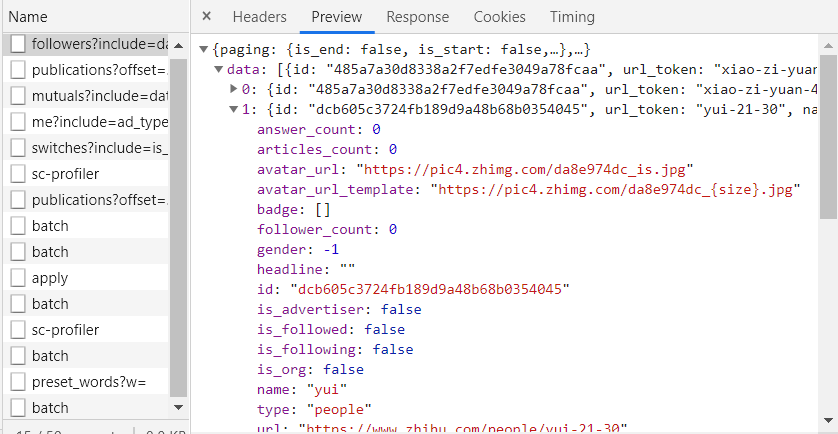

关注ta的：followers_api = "https://www.zhihu.com/api/v4/members/{}/followers?include=data%5B*%5D.answer_count%2Carticles_count%2Cgender%2Cfollower_count%2Cis_followed%2Cis_following%2Cbadge%5B%3F(type%3Dbest_answerer)%5D.topics\u0026offset={}\u0026limit=20" .format(url_token, offset)

ta的关注：followees_api = "https://www.zhihu.com/api/v4/members/{}/followees?include=data%5B*%5D.answer_count%2Carticles_count%2Cgender%2Cfollower_count%2Cis_followed%2Cis_following%2Cbadge%5B%3F(type%3Dbest_answerer)%5D.topics\u0026offset={}\u0026limit=20" .format(url_token, offset)

关注的话题：follow_topic_api = "https://www.zhihu.com/api/v4/members/{}/following-topic-contributions?include=data%5B*%5D.topic.introduction&offset={}&limit=20" .format(url_token, offset)

回答：answer_api = 'https://www.zhihu.com/api/v4/members/{}/answers?include=data%5B*%5D.is_normal%2Cadmin_closed_comment%2Creward_info%2Cis_collapsed%2Cannotation_action%2Cannotation_detail%2Ccollapse_reason%2Ccollapsed_by%2Csuggest_edit%2Ccomment_count%2Ccan_comment%2Ccontent%2Ceditable_content%2Cvoteup_count%2Creshipment_settings%2Ccomment_permission%2Cmark_infos%2Ccreated_time%2Cupdated_time%2Creview_info%2Cexcerpt%2Cis_labeled%2Clabel_info%2Crelationship.is_authorized%2Cvoting%2Cis_author%2Cis_thanked%2Cis_nothelp%2Cis_recognized%3Bdata%5B*%5D.author.badge%5B%3F(type%3Dbest_answerer)%5D.topics%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20data%5B*%5D.question.has_publishing_draft%2Crelationship&offset={}&limit=20&sort_by=created' .format(url_token, offset)

问题：question_api = 'https://www.zhihu.com/api/v4/questions/{}?include=data%5B*%5D.answer_count%2Cfollower_count' .format(qid)

虽然有些提交参数是我们用不到的信息，但经过测试，加入后模仿逼真性更强，尤其是limit，不分页很容易被检测到异常

另外，问题的api params没法通过抓包看到，最开始我是html解析，css选择器找的；后来一个一个试参数试出来了适合的api

爬取的思想是，找一个关注者较多的用户作为seed，数据库里存入该用户的url_token，然后爬取他的关注者和关注，从而获得user表数据

最开始我设计的递归爬取，然而递归次数过多超过最大递归次数会抛出异常，因此改成迭代爬取，将待爬取的送入数据库（不然太耗费内存）以待以后继续

因为封装比较多，具体爬取参见zhihu_spider.py

数据库用pymysql库读写，封装在db.py

## 代理池
### 爬取西刺上的免费代理

In [1]:
import requests
from bs4 import BeautifulSoup
from fake_useragent import UserAgent

pagenum = 4
ua = UserAgent()
encoding = 'utf-8'
s = requests.session()
s.keep_alive = False
http_list = []
https_list = []
root = 'https://www.xicidaili.com/nn/'
for i in range(pagenum):
    r = s.get(root + str(pagenum+1), headers={'User-Agent': ua.random})
    r.encoding = encoding
    soup = BeautifulSoup(r.text, 'html.parser')
    table = soup.find('table', {'id': 'ip_list'})
    for tr in table.find_all('tr')[1:]:
        tds = tr.find_all('td')
        if tds:
            ip = tds[1].string
            port = tds[2].string
            protocol = tds[5].string
            if protocol == 'HTTP':
                http_list.append('http://' + ip + ':' + port)
            elif protocol == 'HTTPS':
                https_list.append('https://' + ip + ':' + port)

质量不是很好，ip被封后大多很长时间内无法使用
### 使用开源项目
查找发现这个代理池不错 https://github.com/SpiderClub/haipproxy

在我的docker上pull一个镜像，开始server端；
再把原始项目clone下来，只保留client部分，运行即可；

此外，我改善了一些地方，改了一下代理调度的轮转方式

In [2]:
from fake_useragent import UserAgent
from client import ProxyFetcher
import time

proxy = None
retries = 5
tries = 0
fetcher = ProxyFetcher('zhihu', strategy='robin', length=5)
while tries < retries:
    proxy = self.fetcher.get_proxy()
    while not proxy:
        time.sleep(10)
        proxy = fetcher.get_proxy()
    proxy = {'http': proxy}

## 自动登录
找了几个项目，很多都过时了，只有这个最好
https://github.com/zkqiang/zhihu-login
因为有js执行部分，需要配置好npm、nodejs

但是它的验证码是手动输入的，需要改成自动输入验证码

## OCR识别验证码
首先尝试使用tesseract-OCR，但在知乎验证码上效果很差

常见的做法可能是用验证码识别服务商的api，但是莫得钱

所以考虑神经网络识别，搭一个CNN很简单，
但是知乎验证码数据集难获取，需要一个一个人工标注

找了找发现了这个项目
https://github.com/littlepai/Unofficial-Zhihu-API
用他的模型恢复参数，然后送入图片即可

知乎的验证码是base64 uri，以data:image/png;base64,开头，
后面是图片的base64编码，注意爬到的中间带有换行符，需要删掉再解码

自动登录时验证码通过 https://www.zhihu.com/api/v3/oauth/captcha?lang=en
获得（中文的需要用zheye，但没必要，识别英文足够了）

爬的数据量过多时，会出现unhuman验证，
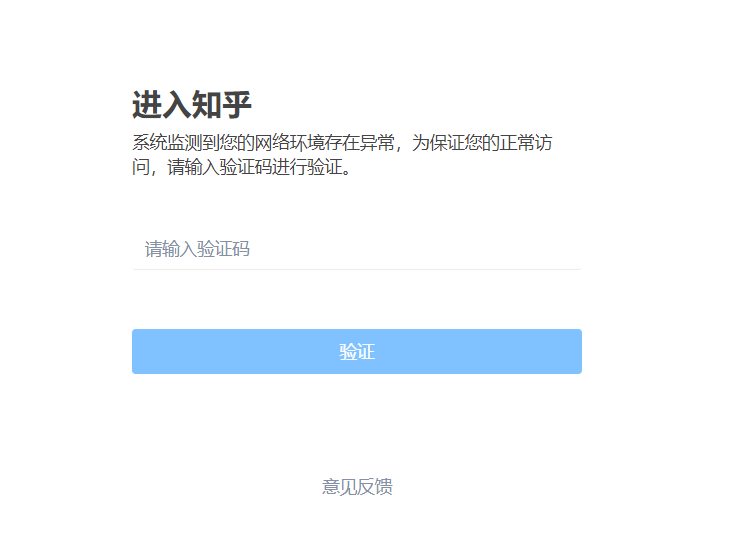

最开始我是用requests-html渲染了页面，然后输入和点击

In [3]:
import re
import base64
from requests_html import HTMLSession
from zhihu_captcha import zhihu_captcha
from PIL import Image

headers = {'accept-language': 'zh-CN,zh;q=0.9',
           'Host': 'www.zhihu.com',
            'Upgrade-Insecure-Requests': '1',
           'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.100 Safari/537.36'
           }
session = HTMLSession()
captcha_model = zhihu_captcha.ZhihuCaptcha('13641535335', '*******')
appealUrl = 'https://www.zhihu.com/account/unhuman?type=unhuman&message=%E7%B3%BB%E7%BB%9F%E7%9B%91%E6%B5%8B%E5%88%B0%E6%82%A8%E7%9A%84%E7%BD%91%E7%BB%9C%E7%8E%AF%E5%A2%83%E5%AD%98%E5%9C%A8%E5%BC%82%E5%B8%B8%EF%BC%8C%E4%B8%BA%E4%BF%9D%E8%AF%81%E6%82%A8%E7%9A%84%E6%AD%A3%E5%B8%B8%E8%AE%BF%E9%97%AE%EF%BC%8C%E8%AF%B7%E8%BE%93%E5%85%A5%E9%AA%8C%E8%AF%81%E7%A0%81%E8%BF%9B%E8%A1%8C%E9%AA%8C%E8%AF%81%E3%80%82&need_login=false'

print('异常检测验证')
r = session.get(appealUrl, headers=headers, allow_redirects=False)
r.html.render(keep_page=True, sleep=1, wait=2)
captchaUrl = r.html.find('img')[0].attrs.get('src')
captchaUrl = re.sub('\n', '', captchaUrl)
f = open('cache/captcha2.gif', 'wb')
f.write(base64.b64decode(captchaUrl.strip('data:image/png;base64,')))
f.close()
im = Image.open('cache/captcha2.gif')
im.save('cache/captcha2.png')
im = Image.open('cache/captcha2.png')
captcha = captcha_model.recgImg(im)
print(captcha)

async def run():
    await r.html.page.type('input', captcha)
    await r.html.page.click('button')
    await r.html.page.close()

session.loop.run_until_complete(run())


过了一个月，写报告前试了一下，结果失败了；
看了一下是知乎改了机制，干脆研究一下api；
验证码的get和post的url都是https://www.zhihu.com/api/v4/anticrawl/captcha_appeal
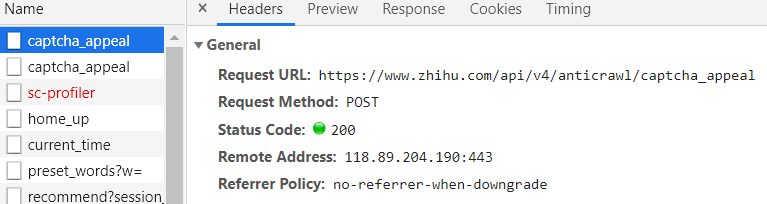

需要注意post的时候headers里没有xsrf会请求失败，
而之前get的时候，session的cookie里保存了xsrf，那么设置cookie就可以

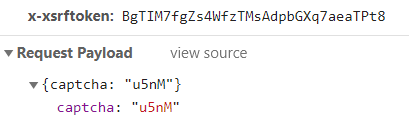

In [4]:
import json
user_agent = 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.100 Safari/537.36'

def appeal(self, url):
    r = self.HTMLSession.get('https://www.zhihu.com/api/v4/anticrawl/captcha_appeal')
    captchaUrl = r.json()['img_base64']
    captchaUrl = re.sub('\n', '', captchaUrl)
    with open('cache/captcha2.gif', 'wb') as f:
        img_base64 = base64.b64decode(captchaUrl.strip('data:image/png;base64,').strip())
        print(img_base64)
        f.write(img_base64)
    im = Image.open('cache/captcha2.gif')
    im.save('cache/captcha2.png')
    im = Image.open('cache/captcha2.png')
    captcha = self.captcha_model.recgImg(im)
    print(captcha)

    r = self.HTMLSession.post('https://www.zhihu.com/api/v4/anticrawl/captcha_appeal',
                              data=json.dumps({"captcha": captcha}),
                              headers={"User-Agent": user_agent,
                                       "referer": 'https://www.zhihu.com/account/unhuman?type=unhuman&message=%E7%B3%BB%E7%BB%9F%E7%9B%91%E6%B5%8B%E5%88%B0%E6%82%A8%E7%9A%84%E7%BD%91%E7%BB%9C%E7%8E%AF%E5%A2%83%E5%AD%98%E5%9C%A8%E5%BC%82%E5%B8%B8%EF%BC%8C%E4%B8%BA%E4%BF%9D%E8%AF%81%E6%82%A8%E7%9A%84%E6%AD%A3%E5%B8%B8%E8%AE%BF%E9%97%AE%EF%BC%8C%E8%AF%B7%E8%BE%93%E5%85%A5%E9%AA%8C%E8%AF%81%E7%A0%81%E8%BF%9B%E8%A1%8C%E9%AA%8C%E8%AF%81%E3%80%82&need_login=false',
                                       'Content-Type': 'application/json',
                                       'x-xsrftoken': self.HTMLSession.cookies._cookies['.zhihu.com']['/']['_xsrf'].value})
    return self.HTMLSession.get(url, allow_redirects=False)

# 知乎数据分析

In [10]:
import pandas as pd
from db import ZhihuDB
import jieba
import jieba.analyse
import jieba.posseg
from wordcloud import WordCloud
from PIL import Image
import numpy as np
import csv
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

db = ZhihuDB()


## 高频话题分析

停用词

In [12]:
stopwords = set([line.strip() for line in open('res/stopwords_zhihu.txt', 'r', encoding='utf-8').readlines()])

查询所有问题的标题，并用jieba分词和词性标注，保留n名词、nr人名、ns地名对应的词语

In [15]:
sql = """
    SELECT title 
    FROM question 
    """
frequencies = dict()
for title in tqdm_notebook(db.fetch_all(sql)):
    # text += ' '.join(set(jieba.cut(title[0])) - stopwords) + ' '
    # text += ' '.join(jieba.analyse.extract_tags(title[0], allowPOS=('n'))) + ' '
    for token in jieba.posseg.cut(title[0]):
        if token.flag[0] != 'n':
            continue
        if token not in frequencies:
            frequencies[token] = 1
        else:
            frequencies[token] += 1

with open('cut_tmp.csv', 'w+', encoding='utf-8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['word', 'flag', 'freq'])
    for token, freq in frequencies.items():
        writer.writerow([token.word, token.flag, freq])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Stranded\AppData\Local\Temp\jieba.cache
Loading model cost 0.855 seconds.
Prefix dict has been built succesfully.


In [17]:
df_n = pd.read_csv('cut_tmp.csv')
df_n = df_n[~df_n['word'].isin(stopwords)]
df_nr = df_n[df_n['flag'] == 'nr']
df_ns = df_n[df_n['flag'] == 'ns']
df_ns.head(10)


,word,flag,freq
13,云,ns,1310
23,中国,ns,34620
41,入门,ns,1983
76,上海,ns,5318
89,日本,ns,12982
100,北京,ns,5905
104,三里屯,ns,30
146,美国,ns,9732
177,纽约,ns,222
179,伦敦,ns,288


dataframe转字典

In [18]:
dfs = {'n': df_n, 'nr': df_nr, 'ns': df_ns}
# texts = {'n': '', 'nr': '', 'ns': ''}
dicts = {'n': dict(), 'nr': dict(), 'ns': dict()}
for key in dfs.keys():
    dfs[key] = dfs[key][['word', 'freq']].groupby('word').sum()
    dicts[key] = dict([(index, freq) for index, freq in zip(dfs[key].index, dfs[key].freq)])

生成词云

In [19]:
font = 'res/canger02_W03.ttf'
mask = np.array(Image.open('res/刘看山.png'))
wc = WordCloud(
    background_color='white',
    mask=mask,  # 若没有该项，则生成默认图片
    font_path=font,  # 中文分词必须有中文字体设置
    stopwords=stopwords
)
for key in dicts.keys():
    wc.generate_from_frequencies(dicts[key])  # 绘制图片
    wc.to_file('output/qu_wordcloud_' + key + '.png')  # 保存图片
#     wc.to_image()

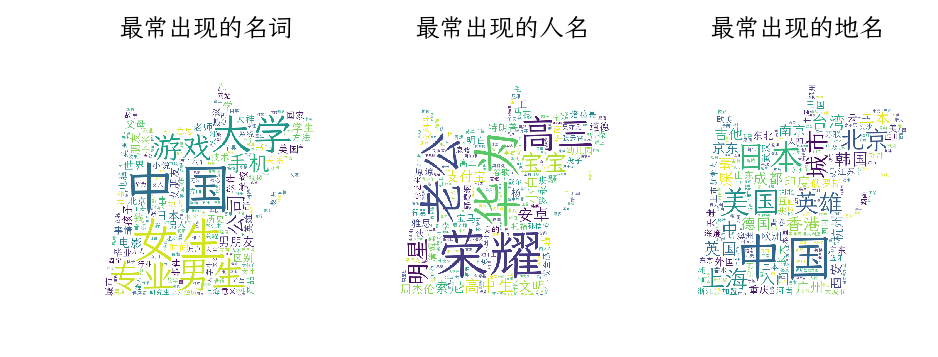

In [20]:
import matplotlib.image as img

font = FontProperties(fname='res/canger02_W03.ttf')
print_dicts = {'n': '名词', 'nr': '人名', 'ns': '地名'}
plt.rcParams['figure.dpi'] = 180

for i, key in enumerate(print_dicts.keys()):
    image = img.imread('output/qu_wordcloud_'+key+'.png')
    plt.subplot(1, 3, i+1)
    plt.imshow(image) # 显示图片
    plt.axis('off') # 不显示坐标轴
    plt.title('最常出现的' + print_dicts[key], fontproperties=font)

plt.show()

## 统计分析最大数、平均数

In [ ]:
avg_sql = 'SELECT avg({}) FROM {}'
avg_sql2 = 'SELECT avg(cnt) FROM (SELECT count(*) as cnt FROM {1} GROUP BY {0}) as tmp '
max_sql1 = 'SELECT {0}, {1} FROM {2} ORDER BY {0} DESC LIMIT 1'
max_sql2 = '''
SELECT max_num, {0} 
FROM (
    SELECT {1}, {2} as max_num 
    FROM {3} 
    ORDER BY {2} DESC 
    LIMIT 1
    ) as t NATURAL JOIN {4}  
'''
max_sql3 = '''
SELECT max_num, {0} 
FROM (
    SELECT {1}, count(*) as max_num 
    FROM {2} 
    GROUP BY {1}
    ORDER BY max_num DESC 
    LIMIT 1
    ) as t NATURAL JOIN {3}  
'''
max_vote, max_vote_qu_title = db.fetch_one(max_sql2.format('title', 'qid', 'vote_num', 'answer', 'question'))
max_cmt, max_cmt_qu_title = db.fetch_one(max_sql2.format('title', 'qid', 'comment_num', 'answer', 'question'))
max_ans, max_ans_title = db.fetch_one(max_sql1.format('answer_count', 'title', 'question'))
max_flw, max_flw_title = db.fetch_one(max_sql1.format('follower_count', 'title', 'question'))
max_toc, max_toc_title = db.fetch_one(max_sql3.format('title', 'tid', 'follow_topic', 'topic'))
max_contirbution, max_con_user = db.fetch_one(max_sql2.format('uname', 'uid', 'contribution', 'follow_topic', 'usr'))
max_tag, max_tag_title = db.fetch_one(max_sql3.format('title', 'tid', 'tag', 'topic'))
max_usr_ans, max_usr_ans_name = db.fetch_one(max_sql1.format('answer_count', 'uname', 'usr'))
max_usr_flw, max_usr_flw_name = db.fetch_one(max_sql1.format('follower_count', 'uname', 'usr'))
max_usr_art, max_usr_art_name = db.fetch_one(max_sql1.format('articles_count', 'uname', 'usr'))

In [15]:
from prettytable import PrettyTable

table = PrettyTable([' ', 'avg_num', 'max_num', 'name_of_the_max (question, topic or usr)'])

table.add_row(['答案赞同数',
               db.fetch_one(avg_sql.format('vote_num', 'answer'))[0],
               max_vote, max_vote_qu_title])
table.add_row(['答案评论数',
               db.fetch_one(avg_sql.format('comment_num', 'answer'))[0],
               max_cmt, max_cmt_qu_title])
table.add_row(['问题回答数',
               db.fetch_one(avg_sql.format('answer_count', 'question'))[0],
               max_ans, max_ans_title])
table.add_row(['问题关注数',
               db.fetch_one(avg_sql.format('follower_count', 'question'))[0],
               max_flw, max_flw_title])
table.add_row(['话题关注数',
               db.fetch_one(avg_sql2.format('tid', 'follow_topic'))[0],
               max_toc, max_toc_title])
table.add_row(['话题问题数',
               db.fetch_one(avg_sql2.format('qid', 'tag'))[0],
               max_tag, max_tag_title])
table.add_row(['用户回答数',
               db.fetch_one(avg_sql.format('answer_count', 'usr'))[0],
               max_usr_ans, max_usr_ans_name])
table.add_row(['用户关注数',
               db.fetch_one(avg_sql.format('follower_count', 'usr'))[0],
               max_usr_flw, max_usr_flw_name])
table.add_row(['用户文章数',
               db.fetch_one(avg_sql.format('articles_count', 'usr'))[0],
               max_usr_art, max_usr_art_name])

print(table)

+------------+----------+---------+------------------------------------------------------------------------------+
|            | avg_num  | max_num |                   name_of_the_max (question, topic or usr)                   |
+------------+----------+---------+------------------------------------------------------------------------------+
| 答案赞同数 | 49.8780  |  283059 |                             北京协和医院有多牛？                             |
| 答案评论数 |  7.3675  |  23642  | 在交通工具上靠着陌生人的肩膀睡着了或是被陌生人靠着肩膀睡着了是怎样一种体验？ |
| 问题回答数 | 61.1616  |  103795 |                          有哪些让你感觉惊艳的名字？                          |
| 问题关注数 | 522.3041 |  569948 |                       你有哪些内行人才知道的省钱诀窍？                       |
| 话题关注数 | 127.4529 |  167525 |                                     电影                                     |
| 话题问题数 |  3.1589  |  33120  |                                     生活                                     |
| 用户回答数 |  5.5125  |  30635  |                                   盐选推荐       

## 尝试分析赞同数频率分布

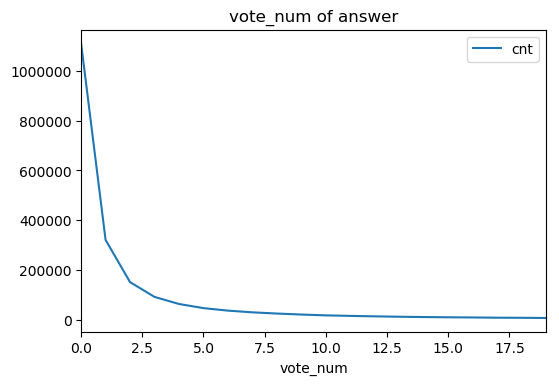

In [22]:
import numpy as np

plt.rcParams['figure.dpi'] = 100

sql = '''
    SELECT {0}, count(*) as cnt
    FROM {1}
    GROUP BY {0}
    '''
df = pd.read_sql(sql.format('vote_num', 'answer'), con=db.conn, index_col='vote_num')
df = df[df.index < 20]
figure = df.plot(title='vote_num' + ' of ' + 'answer')
plt.show()

符合常识

## 统计时期时段和时钟时段问题答案创建的频率分布

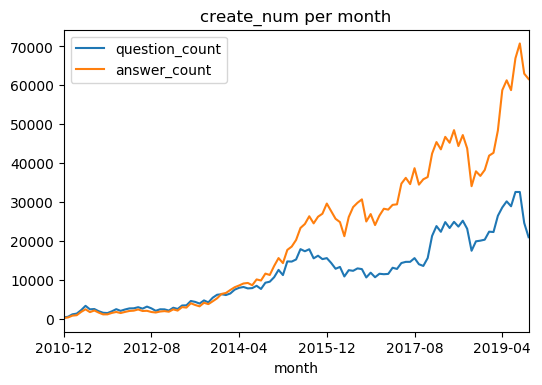

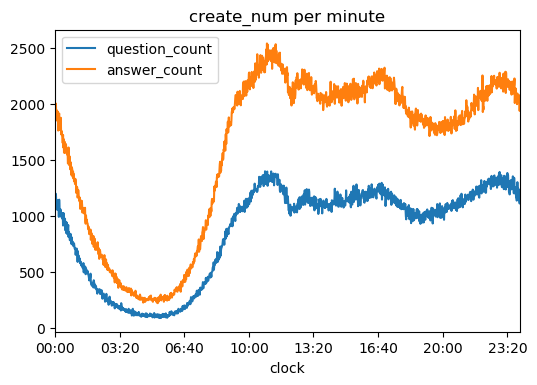

In [ ]:
sql_qu = '''
SELECT from_unixtime(create_time, '%Y-%m') AS month, count(*) AS question_count
FROM question
GROUP BY from_unixtime(create_time, '%Y-%m')
'''
sql_ans = '''
SELECT from_unixtime(create_time, '%Y-%m') AS month, count(*) AS answer_count
FROM answer
GROUP BY from_unixtime(create_time, '%Y-%m')
'''
df_qu = pd.read_sql(sql_qu, db.conn, index_col='month')
df_ans = pd.read_sql(sql_ans, db.conn, index_col='month')
df = df_qu.join(df_ans, how='outer').fillna(0)
df = df[df.index < '2019-11']
df.plot(title='create_num per month')
plt.show()

sql_qu = '''
SELECT from_unixtime(create_time, '%H:%i') AS clock, count(*) AS question_count
FROM question
GROUP BY from_unixtime(create_time, '%H:%i')
'''
sql_ans = '''
SELECT from_unixtime(create_time, '%H:%i') AS clock, count(*) AS answer_count
FROM answer
GROUP BY from_unixtime(create_time, '%H:%i')
'''
df_qu = pd.read_sql(sql_qu, db.conn, index_col='clock')
df_ans = pd.read_sql(sql_ans, db.conn, index_col='clock')
df = df_qu.join(df_ans, how='outer').fillna(0)
df.plot(title='create_num per minute')
plt.show()

## 统计用户性别分布

C:\Users\Stranded\Anaconda3\lib\site-packages\pymysql\cursors.py:170: Warning: (1052, "Column 'gender' in group statement is ambiguous")
  result = self._query(query)


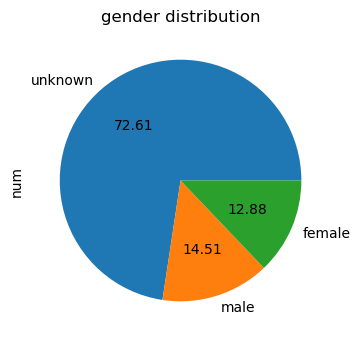

In [ ]:
sql = '''
SELECT 
    CASE gender
        WHEN 0 THEN 'male'
        WHEN 1 THEN 'female'
        WHEN -1 THEN 'unknown'
    END as gender
, count(*) AS num
FROM usr
GROUP BY gender
'''
df = pd.read_sql(sql, db.conn, index_col='gender')
df.plot(kind='pie', title='gender distribution', y='num', autopct='%.2f')
plt.gca().legend_.remove()
plt.show()

## 统计男女用户关注者的性别分布

In [ ]:
sql = '''
SELECT a.gender1, b.gender as gender2, count(*) as num
FROM (
    SELECT gender as gender1, follower
    FROM usr NATURAL JOIN follow ) as a 
    JOIN usr as b on a.follower = b.uid
GROUP BY gender1, gender2
'''
df = pd.read_sql(sql, db.conn)
df['gender2'] = df['gender2'].apply(lambda x: 'male' if x == 0 else ('female' if x == 1 else 'unknown'))

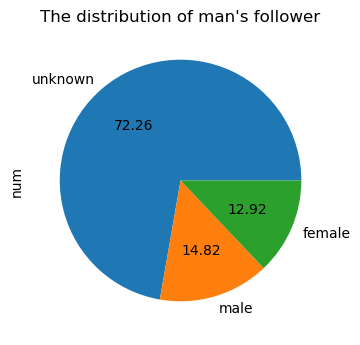

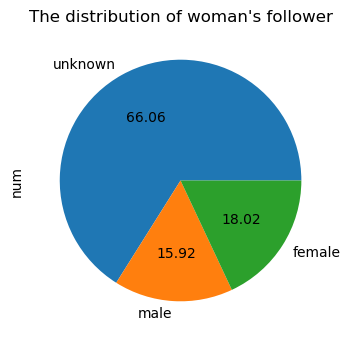

In [ ]:
df_male = df[df['gender1'] == 0][['gender2', 'num']].set_index('gender2')
df_female = df[df['gender1'] == 1][['gender2', 'num']].set_index('gender2')
df_male.plot(kind='pie', title='The distribution of man\'s follower', y='num', autopct='%.2f')
plt.gca().legend_.remove()
plt.show()
df_female.plot(kind='pie', title='The distribution of woman\'s follower', y='num', autopct='%.2f')
plt.gca().legend_.remove()
plt.show()

## 验证六度空间

In [3]:
sql = '''
SELECT * FROM follow AS a
WHERE EXISTS (
        SELECT * FROM follow AS b 
        WHERE a.follower = b.uid )
'''
df = pd.read_sql(sql, db.conn)

In [ ]:
df

In [4]:
import networkx as nx
g = nx.from_pandas_edgelist(df, source='uid', target='follower')

In [6]:
from tqdm import tqdm_notebook
count_dic = dict()

i, sum = 0, g.number_of_nodes()

# Floyd算法快是快一点，但是内存占的忒大了点，服务崩溃了
# length_dic = nx.floyd_warshall(g)

for lens in tqdm_notebook(nx.all_pairs_shortest_path_length(g), total=sum):
    for length in lens[1].values():
        if length not in count_dic:
            count_dic[length] = 1
        else:
            count_dic[length] += 1


In [7]:
def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:

        height = rect.get_height()
        #         print(height)
        if height / 1000 < 0.1:
            continue
        plt.text(rect.get_x() + rect.get_width() * offset[xpos], 1.01 * height,
                 '{}k'.format(int(height / 1000)), ha=ha[xpos], va='bottom', fontproperties=font)

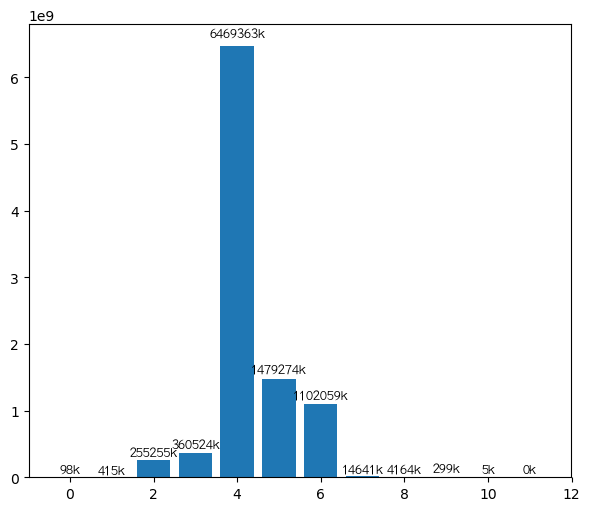

In [28]:
plt.figure(figsize=(7, 6))
fig = plt.bar(x=count_dic.keys(), height=count_dic.values())
autolabel(fig)